# 3. Creating muscle-driven simulations with OpenSim Moco

<a target="_blank" href="https://colab.research.google.com/github/opensim-org/CMBBE2024/blob/main/Demo3_OpenSimMoco/Demo%203%20-%20Muscle-driven%20Simulations%20with%20OpenSim%20Moco.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


## 3.1. Objectives

[OpenSim Moco](https://opensim-org.github.io/opensim-moco-site/) is a software package for creating musculoskeletal simulations using trajectory optimization [[1]](https://doi.org/10.1371/journal.pcbi.1008493). Users define problems by providing an OpenSim model, cost function terms, and additional problem constraints via an easy-to-use scripting interface. Moco rapidly solves trajectory optimization problems via the state-of-the-art direct collocation method.

**Purpose**

The purpose of this tutorial is to introduce users to Moco and showcase new features using the [OpenSim conda package](https://anaconda.org/opensim-org/opensim) and [Jupyter notebooks](https://jupyter.org/). In this tutorial you will:

*   Set up a new conda environment and install OpenSim with Moco.
*   Learn how to replace muscle geometry paths with smooth function-based paths better suited for optimization.
*   Pose and solve a muscle-driven optimization problem for simulating a squat-to-stand motion.
*   Design a passive assistive device at the knee using parameter optimization.
*   Investigate how neural control limitations affect the squat-to-stand motion using muscle synergies.

## 3.2. Set up conda environment and download resources

In the following cell, you will use [condacolab](https://github.com/conda-incubator/condacolab) to install [Miniconda](https://docs.conda.io/en/latest/miniconda.html). If you want to install a different conda distribution (e.g., Anaconda, Mambaforge) check [condacolab's documentation](https://github.com/conda-incubator/condacolab#usage).

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

Don't worry if after executing the previous cell you get an error saying that your session has failed. The reason for this is that condacolab needs to restart the session for the changes to take effect. Because of this, you have to execute the previous cell first, before executing any other cell.

Now, execute the following cell to install the OpenSim conda package.

In [ ]:
!conda install opensim_admin::opensim-moco

Execute the following cell to install the OpenSim Viewer and its dependencies. 

In [ ]:
# Install supporting GLTF and VTK packages for converting mesh files.
!pip install pygltflib
!conda install -c conda-forge vtk

# Mount OpenSim Viewer code base and import the viewport module.
!git clone https://github.com/opensim-org/opensim-viewer-backend.git

import sys
sys.path.append('opensim-viewer-backend')
import osimViewport

Finally, execute the following cell to download the "squat-to-stand" OpenSim model. This is a single leg with 3 DOF and 9 muscles, and the foot is welded to the ground.

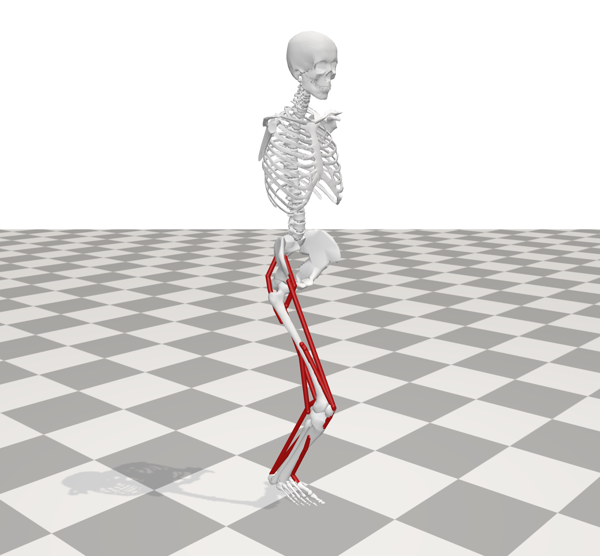

In [ ]:
# @title Download the "squat-to-stand" model and geometry files { display-mode: "form" }
# @markdown After executing this cell, a download button will appear. Click the button to download and extract the zip file containing the "squat-to-stand" model and geometry files.

import ipywidgets as widgets
from IPython.display import display
import requests
import zipfile
import io
import os

# Define the function to download and extract the zip file
def download_and_extract_zip(url):
    try:
        # Get the content of the URL
        response = requests.get(url)
        response.raise_for_status()
        
        # Create a ZipFile object from the downloaded content
        with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
            # Extract all the contents into the working directory
            zip_ref.extractall()
            print("Extraction complete!")
    except requests.exceptions.RequestException as e:
        print(f"Failed to download the file: {e}")
    except zipfile.BadZipFile:
        print("The file is not a valid zip file.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Create a button to trigger the download and extraction
download_button = widgets.Button(
    description='Download Model',
    disabled=False,
    button_style='',
    tooltip='Click to download the squat-to-stand model and geometry files',
    icon='download'
)

# Define the button click event handler
def on_button_click(b):
    url = 'https://drive.google.com/uc?export=download&id=1yVZ_KaYhFQ_kMwR4JbH6o1-POBr2oRMv'
    if url:
        download_and_extract_zip(url)
    else:
        print("Please enter a valid URL.")

# Attach the event handler to the button
download_button.on_click(on_button_click)

# Display the widgets
display(download_button)

## 3.3. Test the installation with the Moco "sliding mass" problem


The following cell imports the OpenSim module and, if successful, shows the current version and build date (**should be 4.5-TODO**).

In [ ]:
import os
import numpy as np
import opensim as osim
osim.GetVersionAndDate()

To test that Moco is working properly, let's solve a problem optimizing the motion of a
one-dimensional "sliding mass" model.

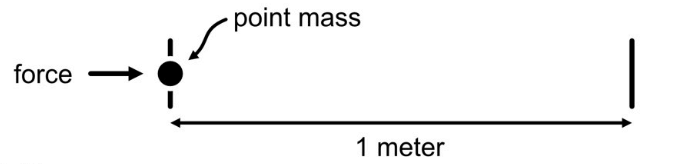

In [ ]:
# @title Run the sliding mass problem { display-mode: "form" }

# Create a simple model of a one-dimensional "sliding" mass.
model = osim.Model()
model.setName('sliding_mass')
model.set_gravity(osim.Vec3(0, 0, 0))
body = osim.Body('body', 2.0, osim.Vec3(0), osim.Inertia(0))
model.addComponent(body)

# Allows translation along x.
joint = osim.SliderJoint('slider', model.getGround(), body)
coord = joint.updCoordinate()
coord.setName('position')
model.addComponent(joint)

actu = osim.CoordinateActuator()
actu.setCoordinate(coord)
actu.setName('actuator')
actu.setOptimalForce(1)
model.addComponent(actu)

body.attachGeometry(osim.Sphere(0.05))

model.finalizeConnections()

# Create MocoStudy.
# ================
study = osim.MocoStudy()
study.setName('sliding_mass')

# Define the optimal control problem.
# ===================================
problem = study.updProblem()

# Model (dynamics).
# -----------------
problem.setModel(model)

# Bounds.
# -------
# Initial time must be 0, final time can be within [0, 5].
problem.setTimeBounds(osim.MocoInitialBounds(0.), osim.MocoFinalBounds(0., 5.))

# Position must be within [-5, 5] throughout the motion.
# Initial position must be 0, final position must be 1.
problem.setStateInfo('/slider/position/value', osim.MocoBounds(-5, 5),
                     osim.MocoInitialBounds(0), osim.MocoFinalBounds(1))
# Speed must be within [-50, 50] throughout the motion.
# Initial and final speed must be 0. Use compact syntax.
problem.setStateInfo('/slider/position/speed', [-50, 50], [0], [0])

# Applied force must be between -50 and 50.
problem.setControlInfo('/actuator', osim.MocoBounds(-50, 50))

# Cost.
# -----
problem.addGoal(osim.MocoFinalTimeGoal())

# Configure the solver.
# =====================
solver = study.initCasADiSolver()
solver.set_num_mesh_intervals(100)

# Now that we've finished setting up the study, print it to a file.
if not os.path.exists('sliding_mass'):
    os.mkdir('sliding_mass')
study.printToXML(os.path.join('sliding_mass', 'sliding_mass.omoco'))

# Solve the problem.
# ==================
solution = study.solve()
# study.visualize(solution)

# Write the solution to a file.
solution.write(os.path.join('sliding_mass', 'sliding_mass_solution.sto'))

# Plot the solution.
# ==================
import matplotlib.pyplot as plt
times = solution.getTimeMat()
position = solution.getStateMat('/slider/position/value')
speed = solution.getStateMat('/slider/position/speed')
actuator = solution.getControlMat('/actuator')

fig, axs = plt.subplots(3, 1, figsize=(6, 6), sharex=True)
axs[0].plot(times, position, 'b', lw=2)
axs[0].set_ylabel('Position (m)')
axs[0].set_xlim([times[0], times[-1]])
axs[1].plot(times, speed, 'b', lw=2)
axs[1].set_ylabel('Speed (m/s)')
axs[1].set_xlim([times[0], times[-1]])
axs[2].plot(times, actuator, 'b', lw=2)
axs[2].set_ylabel('Force (N)')
axs[2].set_xlabel('Time (s)')
axs[2].set_xlim([times[0], times[-1]])
plt.show()

## 3.4. Fit function-based paths for the "squat-to-stand" model 

Use forward integration to create a random trajectory that we can use as a reference when fitting polynomial functions to represent muscle lengths. 

In [ ]:
# Load the model and initialize the multibody system
model = osim.Model('squatToStand_3dof9musc.osim')
state = model.initSystem()

# Set an initial pose.
coordSet = model.updCoordinateSet()
coordSet.get('hip_flexion_r').setValue(state, -40 * (np.pi / 180))
coordSet.get('knee_angle_r').setValue(state, -45 * (np.pi / 180))
coordSet.get('ankle_angle_r').setValue(state, -25 * (np.pi / 180))

# Run a 0.4 second forward simulation.
manager = osim.Manager(model, state)
manager.integrate(0.4)

# Save the states to a file.
table = manager.getStatesTable()
sto = osim.STOFileAdapter()
if not os.path.exists('path_fitting'):
    os.mkdir('path_fitting')
sto.write(table, os.path.join('path_fitting', 'reference_states.sto'))

Now use `PolynomialPathFitter` to randomly sample coordinate values around the reference trajectory. First,muscle lengths and moment arms will be computed from the sampled coordinate values. Coefficients for multivariate polynomial functions representing the muscle lengths are determined using a least-squares fit. Both the muscle lengths and the moment arms (via the polynomial derivatives) are included in the fitting process. 

In [ ]:
# Construct a PolynomialPathFitter object.
fitter = osim.PolynomialPathFitter()

# Set the model.
fitter.setModel(osim.ModelProcessor('squatToStand_3dof9musc.osim'))

# Set the reference states.
table = osim.TimeSeriesTable(os.path.join('path_fitting', 'reference_states.sto'))
fitter.setCoordinateValues(osim.TableProcessor(table))

# Configure settings.
fitter.setMaximumPolynomialOrder(6)
fitter.setNumSamplesPerFrame(10)
fitter.setGlobalCoordinateSamplingBounds(osim.Vec2(-30, 30))
fitter.setUseStepwiseRegression(True)
fitter.setPathLengthTolerance(1e-3)
fitter.setMomentArmTolerance(1e-3)
fitter.setOutputDirectory('path_fitting')

# Run the path fitter.
fitter.run()

Now we'll plot the results to compare the muscle lengths computed from the fitted polynomial functions to the original muscle lengths.

In [ ]:
# @title Plot the path fitting results { display-mode: "form" }
# @markdown Execute this cell to plot the fitted path lengths together with the original path lengths.

from matplotlib import pyplot as plt

# Load the original and fitted path lengths and the path length based on the 
# randomly sampled coordinates values.
lengths = osim.TimeSeriesTable(
    os.path.join('path_fitting', 'squatToStand_path_lengths.sto'))
lengthsFitted = osim.TimeSeriesTable(
    os.path.join('path_fitting', 'squatToStand_path_lengths_fitted.sto'))
lengthsSampled = osim.TimeSeriesTable(
    os.path.join('path_fitting', 'squatToStand_path_lengths_sampled.sto'))
lengthsSampledFitted = osim.TimeSeriesTable(
    os.path.join('path_fitting', 'squatToStand_path_lengths_sampled_fitted.sto'))

# Plot the path lengths. Blue is the original, orange is the fitted.
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
for ilabel, label in enumerate(lengths.getColumnLabels()):
    irow = ilabel // 3
    icol = ilabel % 3
    axs[irow, icol].scatter(
        lengthsSampled.getIndependentColumn(), 
        lengthsSampled.getDependentColumn(label).to_numpy(),
        alpha=0.15, color='blue', s=0.5)
    axs[irow, icol].scatter(
        lengthsSampledFitted.getIndependentColumn(), 
        lengthsSampledFitted.getDependentColumn(label).to_numpy(),
        alpha=0.15, color='orange', s=0.5)
    axs[irow, icol].plot(
        lengths.getIndependentColumn(), 
        lengths.getDependentColumn(label).to_numpy(), 
        label='original', lw=3)
    axs[irow, icol].plot(
        lengthsFitted.getIndependentColumn(), 
        lengthsFitted.getDependentColumn(label).to_numpy(), 
        label='fitted', lw=2.5)
    title = label.replace('/forceset/', '').replace('_length', '')
    axs[irow, icol].set_title(title)
    if not irow and not icol:
        axs[irow, icol].legend()
    if not irow == 2:
        axs[irow, icol].set_xticklabels([])
    else:
        axs[irow, icol].set_xlabel('time (s)')
    if not icol:
        axs[irow, icol].set_ylabel('muscle length (m)')

fig.tight_layout()
plt.show()

Now that we have a good fit for our function-based muscle paths, we can move on to creating a squat-to-stand simulation with Moco.

## 3.5. Muscle-driven predictive simulation of a "squat-to-stand" motion

In this section, we will create a simulation of a motion starting from a squat and ending standing up. This is a **boundary-value problem**, since we need to impose hard constraints at the boundaries (i.e., the initial and final time point) of the problem.

In [ ]:
# Part 1: Create a new MocoStudy.
study = osim.MocoStudy()
study.setName('squat_to_stand_prediction')

# Part 2: Initialize the problem.
problem = study.updProblem()

# Part 3: Construct a model using the function-based paths. To simplify the problem, we
# will ignore tendon compliance, activation dynamics, and passive fiber forces.
modelProcessor = osim.ModelProcessor('squatToStand_3dof9musc.osim')
modelProcessor.append(osim.ModOpScaleMaxIsometricForce(2.0))
modelProcessor.append(osim.ModOpReplaceMusclesWithDeGrooteFregly2016())
modelProcessor.append(osim.ModOpIgnorePassiveFiberForcesDGF())
modelProcessor.append(osim.ModOpIgnoreTendonCompliance())
modelProcessor.append(osim.ModOpIgnoreActivationDynamics())
modelProcessor.append(osim.ModOpScaleActiveFiberForceCurveWidthDGF(1.5))
modelProcessor.append(osim.ModOpReplacePathsWithFunctionBasedPaths(
    os.path.join('path_fitting', 'squatToStand_FunctionBasedPathSet.xml')))
model = modelProcessor.process()
problem.setModel(model)

# Part 3: Set bounds on the problem.
#
# problem.setTimeBounds(initial_bounds, final_bounds)
# problem.setStateInfo(path, trajectory_bounds, inital_bounds, final_bounds)
#
# All *_bounds arguments can be set to a range, [lower upper], or to a
# single value (equal lower and upper bounds). Empty brackets, [], indicate
# using default bounds (if they exist). You may set multiple state infos at
# once using setStateInfoPattern():
#
# problem.setStateInfoPattern(pattern, trajectory_bounds, inital_bounds, ...
#       final_bounds)
#
# This function supports regular expressions in the 'pattern' argument;
# use '.*' to match any substring of the state/control path
# For example, the following will set all coordinate value state infos:
#
# problem.setStateInfoPattern('/path/to/states/.*/value', ...)

# Time bounds
problem.setTimeBounds(0, 1)

# Position bounds: the model should start in a squat and finish 
# standing up.
problem.setStateInfo('/jointset/hip_r/hip_flexion_r/value', 
    [-2, 0.5], -2, 0)
problem.setStateInfo('/jointset/knee_r/knee_angle_r/value', 
    [-2, 0], -2, 0)
problem.setStateInfo('/jointset/ankle_r/ankle_angle_r/value', 
    [-0.75, 0.75], -0.5, 0)

# Velocity bounds: all model coordinates should start and end at rest.
problem.setStateInfoPattern('/jointset/.*/speed', [], 0, 0)

# Part 4: Add a MocoControlCost to the problem.
problem.addGoal(osim.MocoControlGoal('control_effort'))

# Part 5: Configure the solver.
solver = study.initCasADiSolver()
solver.set_num_mesh_intervals(25)
solver.set_optim_finite_difference_scheme('forward')
solver.set_optim_convergence_tolerance(1e-4)
solver.set_optim_constraint_tolerance(1e-4)

# Part 6: Print the study to a file.
if not os.path.exists('squat_to_stand'):
    os.mkdir('squat_to_stand')
study.printToXML(os.path.join('squat_to_stand', 'squat_to_stand.xml'))

# Part 7: Solve! Write the solution to file, and visualize.
predictSolution = study.solve()
solutionFile = os.path.join('squat_to_stand', 'squat_to_stand_prediction_solution.sto')
predictSolution.write(solutionFile)
# study.visualize(predictSolution)

# Part 8: Create a PDF report of the solution.
output = os.path.join('squat_to_stand', 'squat_to_stand_prediction_report.pdf')
report = osim.report.Report(model, 
                            solutionFile,
                            output=output, 
                            bilateral=True)
report.generate()

## 3.6. Visualize the squat-to-stand motion with the OpenSim Viewer

In [ ]:
ovp = osimViewport.osimViewport(200, 300)
ovp.addModelAndMotionFiles('squatToStand_3dof9musc.osim', 
        ['/squat_to_stand/squat_to_stand_prediction_solution.sto'])
ovp.show()

In [ ]:
# @title Download the generated GLTF file to your computer { display-mode: "form" }
# @markdown After executing this cell, a button will appear to download the generated GLTF file to your computer.

import ipywidgets as widgets
from IPython.display import display
from google.colab import files
button = widgets.Button(description="Download the GLTF file!")
output = widgets.Output()

def on_button_clicked(b):
  # Display the message within the output widget.
  with output:
    files.download('/content/squatToStand_3dof9musc.gltf')

button.on_click(on_button_clicked)
display(button, output)

## 3.7. Designing a passive knee assistive device


**<u>Question 1.</u> Before running parameter optimization, how much can you reduce muscle effort via manual parameter design?**

**<u>Question 2.</u> Do the optimized parameters make sense? Explain.**

In [ ]:
# @title Design a passive knee assistive device { display-mode: "form" }
# @markdown Execute the cell to load the interactive device design menu.

import ipywidgets as widgets
from IPython.display import display

def run_device_optimization_squat_to_stand(optimize, stiffness=50, rest_length=0):

    # Part 1: Load the base squat-to-stand MocoStudy.
    study = osim.MocoStudy(os.path.join('squat_to_stand', 'squat_to_stand.xml'))
    problem = study.updProblem()
    solver = osim.MocoCasADiSolver.safeDownCast(study.updSolver())

    # Part 2: Recreate the model, now adding a passive assistive device at the knee
    modelProcessor = osim.ModelProcessor('squatToStand_3dof9musc.osim')
    modelProcessor.append(osim.ModOpScaleMaxIsometricForce(2.0))
    modelProcessor.append(osim.ModOpReplaceMusclesWithDeGrooteFregly2016())
    modelProcessor.append(osim.ModOpIgnorePassiveFiberForcesDGF())
    modelProcessor.append(osim.ModOpIgnoreTendonCompliance())
    modelProcessor.append(osim.ModOpScaleActiveFiberForceCurveWidthDGF(1.5))
    modelProcessor.append(osim.ModOpReplacePathsWithFunctionBasedPaths(
        os.path.join('path_fitting', 'squatToStand_FunctionBasedPathSet.xml')))
    model = modelProcessor.process()

    # The device is a SpringGeneralizedForce acting on the knee angle.
    device = osim.SpringGeneralizedForce('knee_angle_r')
    device.setName('passive_knee_device')
    device.setStiffness(stiffness)
    device.setRestLength(rest_length)
    device.setViscosity(0)
    model.addForce(device)

    # Part 3: Update the problem with the new model.
    problem.setModel(model)

    # Part 4: Add MocoParameters to the problem to optimize device stiffness and rest 
    # length.
    if optimize:
        stiffness = osim.MocoParameter('stiffness', 
                '/forceset/passive_knee_device', 'stiffness', osim.MocoBounds(0, 400))
        problem.addParameter(stiffness)

        rest_length = osim.MocoParameter('rest_length', 
                '/forceset/passive_knee_device', 'rest_length', osim.MocoBounds(-1, 1))
        problem.addParameter(rest_length)

    # Part 5: Update the solver with the new problem (i.e., new model and parameters).
    solver.resetProblem(problem)

    # Part 6: Set solver parameter optimization flag.
    # -----------------------------------------------
    # This flag tells MocoCasADiSolver that initSystem() calls on the model are 
    # unnecessary to optimize the parameters. Other parameters (e.g., body mass) 
    # require initSystem(), since they change the model's underlying multibody 
    # system in Simbody. Since changing parameters in SpringGeneralizedForce does 
    # not change the multibody system, we can set this flag to false to speed up 
    # the optimization.
    solver.set_parameters_require_initsystem(False)

    # Part 7: Solve the problem.
    deviceSolution = study.solve()
    if not os.path.exists('device_optimization'):
        os.mkdir('device_optimization')
    solutionFile = os.path.join('device_optimization', 
        'squat_to_stand_device_optimization_solution.sto')
    deviceSolution.write(solutionFile)
    # study.visualize(deviceSolution)

    # Part 8: Print the parameter values.
    if optimize:
        parameters = deviceSolution.getParameters().to_numpy()
        print(f'Optimized stiffness: {parameters[0]:.2f} Nm/rad')
        print(f'Optimized rest length: {parameters[1]:.2f} rad')
        print(f'Muscle effort: {deviceSolution.getObjective():.3f}\n')
    else:
        print(f'Using stiffness: {stiffness:.2f} Nm/rad')
        print(f'Using rest length: {rest_length:.2f} rad')
        print(f'Muscle effort: {deviceSolution.getObjective():.3f}\n')

    # Part 9: Create a PDF report of the solution.
    output = os.path.join('device_optimization',
            'squat_to_stand_device_optimization_report.pdf')
    ref_files = []
    ref_files.append(os.path.join('squat_to_stand', 
            'squat_to_stand_prediction_solution.sto'))
    report = osim.report.Report(model, 
                                solutionFile,
                                output=output, 
                                ref_files=ref_files,
                                bilateral=True)
    report.generate()


def on_submit(b):
    if mode_selector.value == 'Manual':
        print('Testing manual design...')
        run_device_optimization_squat_to_stand(False, 
                stiffness_slider.value, rest_length_slider.value)
    else:
        print('Optimizing design...')
        run_device_optimization_squat_to_stand(True)

# Define layout for consistent width and alignment
common_layout = widgets.Layout(width='400px')

# Create mode selector dropdown with the common layout
mode_selector = widgets.Dropdown(
    options=['Manual', 'Optimization'],
    value='Manual',
    description='Design Mode:',
    disabled=False,
    layout=common_layout
)

# Define layout for right-aligning the description and common width for labels
description_layout = widgets.Layout(display='flex', justify_content='flex-end', width='150px')

# Define slider layout with common width
slider_layout = widgets.Layout(width='250px')

# Create sliders with the defined layout
stiffness_slider = widgets.FloatSlider(
    value=0.0,
    min=0.0,
    max=400.0,
    step=0.1,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    style={'description_width': 'initial'},
    layout=slider_layout
)

rest_length_slider = widgets.FloatSlider(
    value=0.0,
    min=-1.0,
    max=1.0,
    step=0.01,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    style={'description_width': 'initial'},
    layout=slider_layout
)

# Create label widgets for alignment
stiffness_label = widgets.Label(value='stiffness [N-m/rad]:', layout=description_layout)
rest_length_label = widgets.Label(value='rest length [rad]:', layout=description_layout)

# Combine labels and sliders into HBox
stiffness_hbox = widgets.HBox([stiffness_label, stiffness_slider], layout=common_layout)
rest_length_hbox = widgets.HBox([rest_length_label, rest_length_slider], layout=common_layout)

# Create submit button with common layout
submit_button = widgets.Button(
    description='Submit',
    disabled=False,
    button_style='',
    tooltip='Click to submit',
    icon='check',
    layout=common_layout
)

# Mode change handler
def on_mode_change(change):
    if change['new'] == 'Manual':
        stiffness_slider.value = 0.0
        rest_length_slider.value = 0.0
        stiffness_slider.disabled = False
        rest_length_slider.disabled = False
    else:
        stiffness_slider.value = 0.0
        rest_length_slider.value = 0.0
        stiffness_slider.disabled = True
        rest_length_slider.disabled = True

mode_selector.observe(on_mode_change, names='value')

submit_button.on_click(on_submit)

# Display widgets
display(widgets.VBox([mode_selector, stiffness_hbox, rest_length_hbox, submit_button]))

# Initialize state based on the current mode
on_mode_change({'new': mode_selector.value})


## 3.8. Synergy-driven "squat-to-stand" motion

**<u>Question 1.</u> What is the smallest number of synergies where the squat-to-stand motion is possible?**

**<u>Question 2.</u> Can you incorporate a passive device from the previous section to make standing possible with reduced neural control?**

In [ ]:
# @title Run a synergy-driven squat-to-stand optimization { display-mode: "form" }
# @markdown Execute the cell to load the menu for specifying the number of synergies.

import ipywidgets as widgets
from IPython.display import display, Markdown
import numpy as np

# Suppress scikit-learn warnings.
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

def printmd(string, color):
    display(Markdown(f'<font color={color} size="4">{string}</font>'))

def run_synergy_driven_squat_to_stand(num_synergies):

    # Part 1: Load the base squat-to-stand MocoStudy.
    study = osim.MocoStudy(os.path.join('squat_to_stand', 'squat_to_stand.xml'))
    problem = study.updProblem()
    solver = osim.MocoCasADiSolver.safeDownCast(study.updSolver())

    # Part 2: Recreate the model, now adding a passive assistive device at the knee
    modelProcessor = osim.ModelProcessor('squatToStand_3dof9musc.osim')
    modelProcessor.append(osim.ModOpScaleMaxIsometricForce(2.0))
    modelProcessor.append(osim.ModOpReplaceMusclesWithDeGrooteFregly2016())
    modelProcessor.append(osim.ModOpIgnorePassiveFiberForcesDGF())
    modelProcessor.append(osim.ModOpIgnoreTendonCompliance())
    modelProcessor.append(osim.ModOpIgnoreActivationDynamics())
    modelProcessor.append(osim.ModOpScaleActiveFiberForceCurveWidthDGF(1.5))
    modelProcessor.append(osim.ModOpReplacePathsWithFunctionBasedPaths(
        os.path.join('path_fitting', 'squatToStand_FunctionBasedPathSet.xml')))
    model = modelProcessor.process()
    model.initSystem()

    # Part 3: Load the solution to the squat-to-stand prediction to extract the muscle
    # controls.
    prevSolution = osim.MocoTrajectory(
            os.path.join('squat_to_stand', 'squat_to_stand_prediction_solution.sto'))
    controls = prevSolution.exportToControlsTable()

    # Part 4: Use non-negative matrix factorization (NNMF) to extract a set of muscle
    # synergies.
    from sklearn.decomposition import NMF
    nmf = NMF(n_components=num_synergies, init='random', random_state=0, max_iter=1000)

    A = controls.getMatrix().to_numpy()
    W = nmf.fit_transform(A)
    H = nmf.components_

    # Scale W and H assuming that the elements of H are all 0.5. This prevents the 
    # synergy excitations and synergy vector weights from being too small or too large.
    scaleVec = 0.5*np.ones(H.shape[1])
    for i in range(num_synergies):
        scale = np.linalg.norm(scaleVec) / np.linalg.norm(H[i, :])
        H[i, :] *= scale
        W[:, i] /= scale

    # Part 5: Add a SynergyController for the model's right leg.
    controller = osim.SynergyController()
    controller.setName("synergy_controller")
    # The number of actuators connected to the controller defines the number of
    # weights in each synergy vector expected by the controller.
    for name in controls.getColumnLabels():
        controller.addActuator(
                osim.Muscle.safeDownCast(model.getComponent(name)))
    # Adding a synergy vector increases the number of synergies in the
    # controller by one. This means that the number of Input control 
    # signals expected by the controller is also increased by one.
    for i in range(num_synergies):
        synergyVector = osim.Vector(H.shape[1], 0.0)
        for j in range(H.shape[1]):
            synergyVector.set(j, H[i, j])
        controller.addSynergyVector(synergyVector)
    model.addController(controller)
    model.finalizeConnections()
    model.initSystem()

    # Part 6: Update the problem with the new model.
    problem.setModel(model)

    # Part 7: Set bounds on the synergy excitations and update the weight on the 
    # synergy excitations in the control effort cost term.
    effort = osim.MocoControlGoal.safeDownCast(problem.updGoal("control_effort"))
    # Enabling this flag means muscle excitations are ignored in the effort cost.
    effort.setIgnoreControlledActuators(True)
    for i in range(num_synergies):
        name = f'/controllerset/synergy_controller/synergy_excitation_{i}'
        problem.setInputControlInfo(name, [0, 1.5*np.max(W)])
        effort.setWeightForControl(name, 0.1)

    # Part 8: Update the solver with the new problem.
    solver.resetProblem(problem)

    # Part 9: Solve!
    solutionSealed = study.solve()
    solution = solutionSealed.unseal()
    if solution.success():
        printmd(f'**Success!** Problem with {num_synergies} synergies converged!', 
                'green')
    else:
        printmd(f'**Failure.** Problem with {num_synergies} synergies did not converge.', 
                'red')

    # This function computes the model control values from the
    # SynergyController in the model and inserts them into the solution.
    solution.generateControlsFromModelControllers(model)
    # study.visualize(solution)

    # Part 10: Write the solution to a Storage file.
    if not os.path.exists('muscle_synergies'):
            os.mkdir('muscle_synergies')
    solutionFile = os.path.join('muscle_synergies', 
            f'squat_to_stand_{num_synergies}_muscle_synergies_solution.sto')
    solution.write(solutionFile)

    # Part 11: Create a PDF report of the solution.
    output = os.path.join('muscle_synergies', 
            f'squat_to_stand_{num_synergies}_muscle_synergies_solution.pdf')
    ref_files = []
    ref_files.append(os.path.join('squat_to_stand', 
            'squat_to_stand_prediction_solution.sto'))
    report = osim.report.Report(model, 
                                solutionFile,
                                output=output, 
                                ref_files=ref_files,
                                bilateral=True)
    report.generate()

def on_submit(b):
    run_synergy_driven_squat_to_stand(slider.value)


common_layout = widgets.Layout(width='300px')

# Define layout for right-aligning the description and common width for labels
description_layout = widgets.Layout(display='flex', justify_content='flex-end', width='100px')

# Define slider layout with common width
slider_layout = widgets.Layout(width='250px')

slider = widgets.IntSlider(
    value=5,
    min=1,
    max=8,
    step=1,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    # readout_format='.1f',
    style={'description_width': 'initial'},
    layout=slider_layout
)

# Create label widgets for alignment
slider_label = widgets.Label(value='no. synergies:', layout=description_layout)

# Combine labels and sliders into HBox
slider_hbox = widgets.HBox([slider_label, slider], layout=common_layout)

submit_button = widgets.Button(
    description='Submit',
    disabled=False,
    button_style='',
    tooltip='Click to submit',
    icon='check',
    layout=common_layout
)

submit_button.on_click(on_submit)

display(widgets.VBox([slider_hbox, submit_button]))

## 3.9. Conclusion

In this tutorial you used [condacolab](https://github.com/conda-incubator/condacolab) to install [Miniconda](https://docs.conda.io/en/latest/miniconda.html) in [Google Colab](https://colab.research.google.com/?hl=en). Then, you  installed Conda [OpenSim](https://opensim.stanford.edu/) in the Miniconda environment, and you tested it by creating and simulating a simple pendulum and simulating. Finally, you plotted the positions of the pendulum using [matplotlib](https://matplotlib.org/).

## 3.10. Useful Links

> **OpenSim Moco Website:** https://opensim-org.github.io/opensim-moco-site/
>
> **OpenSim Moco Publication:** https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008493
>
> **OpenSim SimTK Website:** https://simtk.org/projects/opensim

## 3.11 Acknowledgments

Thanks to [OpenSimColab](https://simtk.org/projects/opencolab) project [[2]](https://doi.org/10.1080/10255842.2022.2104607) for creating the first OpenSim Conda package.

## 3.12. References

> [1] Dembia CL, Bianco NA, Falisse A, Hicks JL, Delp SL (2020) **OpenSim Moco: Musculoskeletal optimal control.** PLOS Computational Biology 16(12): e1008493. https://doi.org/10.1371/journal.pcbi.1008493
>
> [2] Mokhtarzadeh, H., Jiang, F., Zhao, S., & Malekipour, F. (2022). **OpenColab project: OpenSim in Google colaboratory to explore biomechanics on the web.** *Computer Methods in Biomechanics and Biomedical Engineering*, 1–9. https://doi.org/10.1080/10255842.2022.2104607